In [1]:
import itertools
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
from functools import lru_cache

In [2]:
@lru_cache(maxsize=None)
def p_pmf(x, mu):
    return poisson.pmf(x, mu)

def alpha_level(mu, epsilon):
    left, right = 0, 0
    iterator = itertools.count()
    for x in iterator:
        y = p_pmf(x, mu)
        if y >= epsilon:
            left = x
            break
    for x in iterator:
        y = p_pmf(x, mu)
        if y < epsilon:
            right = x
            break
    return left, right


def segment(start, stop, step=1):
    return range(start, stop + 1, step)


@dataclass
class PickUpPoint:
    issuance_mu: int
    returns_mu: int
    max_cars: int


def apply_action(state, action):
    first, second = state
    return first - action, second + action


def clip(v, from_v, to_v):
    return max(from_v, min(to_v, v))

@dataclass
class JackCarRental:
    first_pickup: PickUpPoint
    second_pickup: PickUpPoint
    point_to_point_movement_cost: float
    point_to_point_movement_max_cars: int
    first_to_second_free_movement = 0
    second_to_first_free_movement = 0
    rent_prize: float
    theta = 65
    theta_degrade = 0.5
    epsilon = 0.01
    gamma = 0.9

    def iterate_states(self):
        for i in segment(0, self.first_pickup.max_cars):
            for j in segment(0, self.second_pickup.max_cars):
                yield i, j

    def iterate_actions(self, state):
        d = self.point_to_point_movement_max_cars
        for i in segment(-d, d):
            first, second = apply_action(state, i)
            if 0 <= first <= self.first_pickup.max_cars and \
                    0 <= second <= self.second_pickup.max_cars:
                yield i

    def action_cost(self, action):
        free_first_to_second = self.first_to_second_free_movement
        free_second_to_first = self.second_to_first_free_movement
        free_ride = free_first_to_second if action >= 0 else free_second_to_first

        return max(abs(action) - free_ride, 0) * self.point_to_point_movement_cost

    def action_evaluation(self, state, action, values):
        balance = 0

        balance += self.action_cost(action)

        first, second = apply_action(state, action)

        for first_cars_issued in segment(*alpha_level(self.first_pickup.issuance_mu, self.epsilon)):
            for first_cars_returned in segment(*alpha_level(self.first_pickup.returns_mu, self.epsilon)):
                for second_cars_issued in segment(*alpha_level(self.second_pickup.issuance_mu, self.epsilon)):
                    for second_cars_returned in segment(*alpha_level(self.second_pickup.returns_mu, self.epsilon)):
                        first_actually_issued, second_actually_issued = \
                            min(first, first_cars_issued), min(second, second_cars_issued)

                        new_state = \
                            min(first - first_actually_issued + first_cars_returned, self.first_pickup.max_cars), \
                                min(second - second_actually_issued + second_cars_returned, self.second_pickup.max_cars)

                        income = (first_actually_issued + second_actually_issued) * self.rent_prize
                        probability = \
                            p_pmf(first_cars_issued, self.first_pickup.issuance_mu) * \
                            p_pmf(first_cars_returned, self.first_pickup.returns_mu) * \
                            p_pmf(second_cars_issued, self.second_pickup.issuance_mu) * \
                            p_pmf(second_cars_returned, self.second_pickup.returns_mu)
                        balance += probability * (income + self.gamma * values[new_state])
        return balance

    def strategy_evaluation(self, values, strategy, curr_theta, i=0):
        for j in itertools.count():
            new_values = np.zeros_like(values)
            delta = 0
            print()
            print(f'eval{i}:{j}')
            for s in self.iterate_states():
                new_values[s] = self.action_evaluation(s, strategy[s], values)
                delta = max(delta, abs(values[s] - new_values[s]))
                print('.', end='', flush=True)
            values = new_values
            if delta < curr_theta:
                break
        return new_values

    def strategy_improvement(self, values, old_strategy, i=0):
        policy_stable = True
        new_strategy = np.zeros_like(old_strategy)
        print()
        print(f'improvement{i}')
        for s in self.iterate_states():
            old_action = old_strategy[s]

            new_action = old_action
            new_action_balance = 0
            for a in self.iterate_actions(s):
                b = self.action_evaluation(s, a, values)
                # if a < 0:
                #     print(new_action, new_action_balance, b)
                if b > new_action_balance:
                    new_action_balance = b
                    new_action = a

            new_strategy[s] = new_action

            if old_action != new_action:
                policy_stable = False
                print(f'improvement{i}', s, old_strategy[s], new_strategy[s], policy_stable)
            else:
                print('.', end='', flush=True)
        return new_strategy, policy_stable

    def get_optimal_jack_strategy(self):
        shape = self.first_pickup.max_cars + 1, self.second_pickup.max_cars + 1
        values = np.zeros(shape)
        strategy = np.zeros(shape, dtype=int)
        strategy_history = [strategy]
        curr_theta = self.theta
        i = 0
        while True:
            values = self.strategy_evaluation(values, strategy, curr_theta, i)
            strategy, policy_stable = self.strategy_improvement(values, strategy, i)
            strategy_history.append(strategy)
            if policy_stable:
                break
            curr_theta *= self.theta_degrade
            i += 1
        return values, strategy, strategy_history


rental = JackCarRental(first_pickup=PickUpPoint(3, 3, 20), second_pickup=PickUpPoint(4, 2, 20),
                       point_to_point_movement_cost=-2, point_to_point_movement_max_cars=5, rent_prize=10)
# rental.gamma = 0.1
v, pi, history = rental.get_optimal_jack_strategy()


eval0:0
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................
eval0:1
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................
improvement0
......improvement0 (0, 6) 0 -1 False
improvement0 (0, 7) 0 -1 False
improvement0 (0, 8

In [3]:
v

array([[339.69243036, 349.54735154, 359.27597079, 368.73352695,
        377.78849271, 386.36848225, 394.46134362, 402.20499871,
        409.83039869, 417.10859115, 424.28811605, 431.07091038,
        437.51230107, 443.88792345, 449.92317588, 455.64639928,
        461.07822926, 466.3054624 , 471.38399236, 476.20079119,
        480.76363662],
       [349.44450583, 359.29935258, 369.02760249, 378.48421163,
        387.53748768, 396.1150812 , 404.20499871, 411.83039869,
        419.10859115, 426.28811605, 433.07091038, 439.51230107,
        445.88792345, 451.92317588, 457.64639928, 463.07822926,
        468.3054624 , 473.38399236, 478.20079119, 482.76363662,
        487.0669799 ],
       [358.7757482 , 368.63025096, 378.3567964 , 387.8090451 ,
        396.8545725 , 405.42125948, 413.49795101, 421.10859115,
        428.28811605, 435.07091038, 441.51230107, 447.88792345,
        453.92317588, 459.64639928, 465.07822926, 470.3054624 ,
        475.38399236, 480.20079119, 484.76363662, 489.0669

In [4]:
pi

array([[ 0,  0,  0,  0,  0,  0,  0, -1, -1, -2, -2, -2, -3, -3, -3, -3,
        -3, -4, -4, -4, -4],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -2, -2, -2, -2, -2,
        -3, -3, -3, -3, -3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -2,
        -2, -2, -2, -2, -2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
        -1, -1, -1, -1, -2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, -1, -1],
       [ 1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 2,  2,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 3,  2,  2,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 3,  3,  2,  2,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [ 4,  3,  3,  2,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,

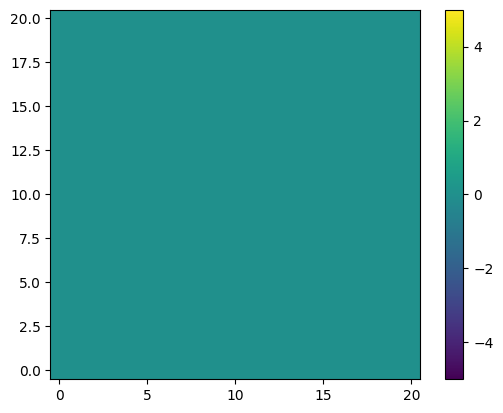

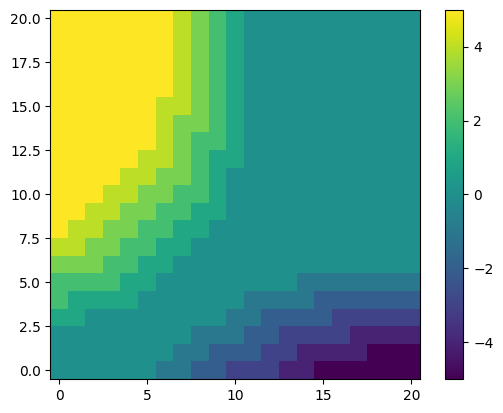

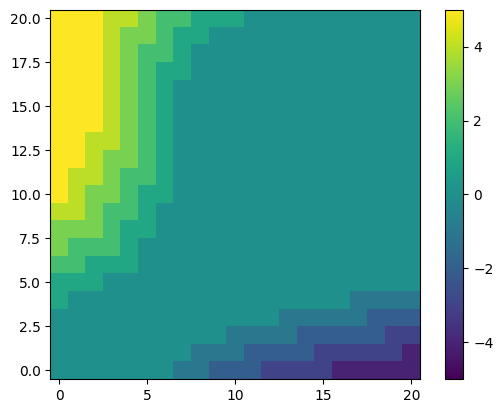

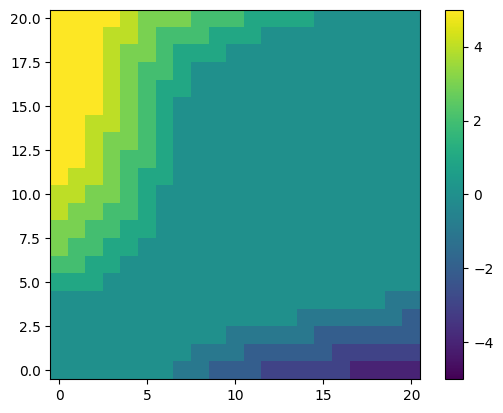

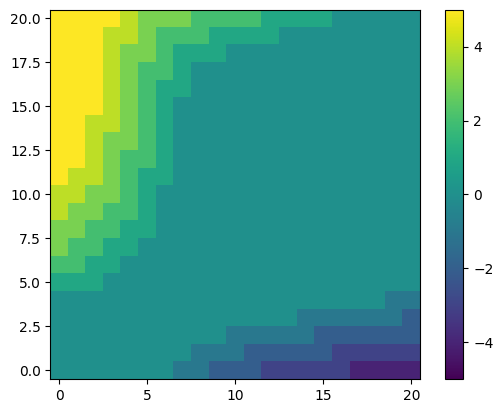

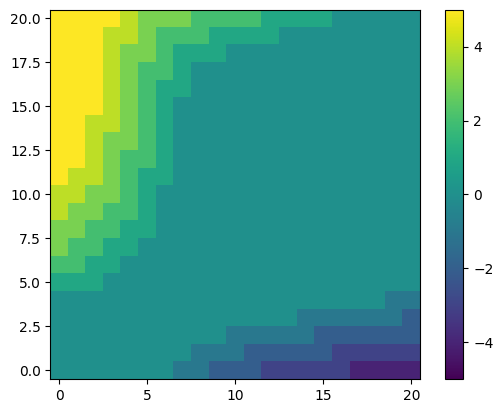

In [5]:
for h in history:
    plt.imshow(h, cmap='viridis', vmin=-5, vmax=5, origin='lower')
    plt.colorbar()
    plt.show()